In [ ]:
"""
This notebook explains classical KF and give a simple example
The code is adapted from here: https://arxiv.org/ftp/arxiv/papers/1204/1204.0375.pdf
And here: https://stackoverflow.com/questions/13901997/kalman-2d-filter-in-python
"""

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
"""
First, let's define the predict and update algorithms for the Kalman filter. 
If you need to read the equations, refer to https://en.wikipedia.org/wiki/Kalman_filter

   Parameters:
        x: initial state
        P: initial uncertainty coveriance matrix
        measurement: observed postion (same shape as H*x)
        R: measurement noise (same shape as H)
        motion: external motion added to state vector x
        Q: motion noise (same shape as P)
        A: next state function: x_prime = F*x (n x n matrix)
        B: The input effect matrix (n x 1)
        H: measurement function: position z=H*x
        
        Return: the updated and predicted new values for (x,P)
    """
def kf_predict(X,P,A,Q,B,U):
    X = np.dot(A,X) + np.dot(B,U) #predict the state (a piori)
    P = np.dot(A, np.dot(P,A.T)) +Q  #estimate the covariance matrix (a piori)
    return(X,P)
    
def kf_update(X,P,Y,H,R):
    V = Y.T-np.dot(H,X) #innovation or measurement residual
    S = np.dot(H, np.dot(P,H.T))+R #measurement prediction covariance
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))  #Kalman gain
    X = X + np.dot(K,V)  #now estimate the mean (a posteriori)
    P = P - np.dot(K,np.dot(S,K.T)) #estimate the covariance matrix (a posteriori)
    return(X,P,K,V,S,H)

In [3]:
"""
Now example: Tracking of mobile in wireless network
Initialisation of state matrices
Please note that for KF the results are very sensitive to parameters, I would suggest to play abit with the parameters
"""

X = np.array([[0.0],[0.0],[0.1],[0.1]]) #first two for location (0,0), later two for velocity (0.1,0.1) at a 2-D lattice x,y
#P = np.diag((0.01,0.01,0.01,0.01))
P = np.matrix(np.eye(4))*1000 # initial uncertainty
dt = 0.1 #this will shape the state transition model A
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
H = np.array([[1,0,0,0],[0,1,0,0]])    
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1))
#Measurement matrices
N=20
true_x = np.linspace(0.0, 10.0, N)
true_y = true_x**2
observed_x = true_x + 0.1*np.random.random(N)*true_x
observed_y = true_y + 0.1*np.random.random(N)*true_y
Y= np.vstack((observed_x,observed_y)).T
result = []

R =0.1**2

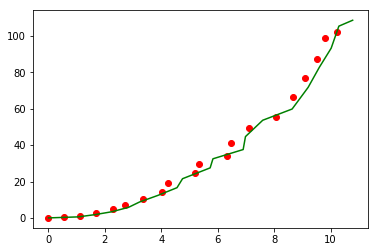

In [4]:
#now the main KF loop
for i in range(0,N):
    
    #print(X)
    (X,P,K,V,S,H)=kf_update(X,P,np.array([Y[i]]),H,R)
    (X,P)= kf_predict(X,P,A,Q,B,U)
    #print(K)
    result.append((X[:2]).tolist())
#plotting
kalman_x, kalman_y = zip(*result)
plt.plot(observed_x, observed_y, 'ro')
plt.plot(kalman_x, kalman_y, 'g-')
#plt.show()